Sometimes the GPU use during training was so intense that the notebook died once the training was done. 

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.49 GiB. GPU 0 has a total capacity of 14.74 GiB of which 3.15 GiB is free. Process 3223 has 11.59 GiB memory in use. Of the allocated memory 10.87 GiB is allocated by PyTorch, and 601.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


So in our pipeline the .pth file was automatically downloaded so in that case we could just upload the model and generate our submission

they also rewarded us with a badge

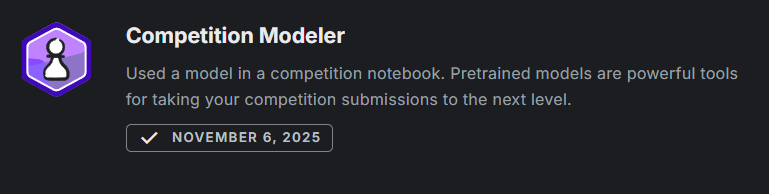

In [ ]:
# --- Imports ---
import torch, pandas as pd, gc
from tqdm import tqdm

# --- Paths / constants ---
FINAL_SAVE_PATH = "/kaggle/input/model4/pytorch/default/1/giga_vae_model_giga_vae_model_1762536102_best.pth"

print(f"Loading BEST model from {FINAL_SAVE_PATH} for inference...")
model = VAETranslator(dropout=0.4, hidden_dim=8192, latent_dim=1536, output_dim=1536).to(device)
model.load_state_dict(torch.load(FINAL_SAVE_PATH))
model.eval() # <-- This is CRITICAL. Ensures model(chunk) gives deterministic output
print("Best model loaded.")

with torch.no_grad():
    preds_list = []
    for i in tqdm(range(0, len(tx_test_t), 1024), desc="Generating Sub"):
        chunk = tx_test_t[i:i+1024].to(device)
        preds_list.append(model(chunk)) # model is in .eval() mode
    preds = torch.cat(preds_list, dim=0).cpu().numpy()

test_ids = test_data["captions/ids"].astype(int)
submission = pd.DataFrame({
    "id": test_ids,
    "embedding": [list(map(float, row)) for row in preds]
})

submission_filename = f"submission_giga_vae_run_{RUN_ID}.csv"
submission.to_csv(submission_filename, index=False)
print(f"\n✅ {submission_filename} saved successfully.")

# --- Final Validation (on FULL val set, now OOM-safe) ---
print("Calculating final validation scores on full val set...")
rec_full = recall_at_k(model, tx_val_t, im_train_t_unique, img_indices_val, chunk_size=1024)
print("\n--- Full Validation Results ---")
print(f"Validation Recall@1:  {rec_full['R@1']:<8.4f}")
print(f"Validation Recall@5:  {rec_full['R@5']:<8.4f}")
print(f"Validation Recall@10: {rec_full['R@10']:<8.4f}")
print(f"Validation Recall@50: {rec_full['R@50']:<8.4f}")v